In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

In [3]:
import pickle

data = pickle.load(open('./data/data.pkl', 'rb'))

X, y, date_mask = data['X'], data['y'], data['date_mask']

print(X.shape, y.shape, date_mask.shape)

(179863, 7, 6) (179863,) (179863,)


In [26]:
span = 1

results = []
for i in tqdm(range(0, 180 // span)):
    # X_train = X[(date_mask >= 0 + (i-1)*span) & (date_mask < 0 + i*span)]
    X_train = X[(date_mask < 0 + i*span)]
    X_test = X[(date_mask >= 0 + i*span) & (date_mask < 0 + (i+1)*span)]
    # y_train = y[(date_mask >= 0 + (i-1)*span) & (date_mask < 0 + i*span)]
    y_train = y[(date_mask < 0 + i*span)]
    y_test = y[(date_mask >= 0 + i*span) & (date_mask < 0 + (i+1)*span)]
    
    
    model = xgb.XGBClassifier()  # 创建一个 XGBoost 分类器
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1, 1))
    
    predictions = model.predict(X_test.reshape(X_test.shape[0], -1))
    # print("Accuracy:", accuracy_score(y_test, predictions))
    # print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    
    y_pred_proba = model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # print("AUC:", roc_auc)
    
    results.append({'roc_auc': roc_auc, 'acc': accuracy_score(y_test, predictions), 'date': i})
    # break

100%|██████████| 180/180 [00:51<00:00,  3.47it/s]


In [27]:
df = pd.read_csv('./log/test.csv', index_col=0)

df['created_day'] = pd.to_datetime(df['created_day'], format='%Y-%m')
df.groupby('created_day').agg({
    'perf_next30': 'mean'
})


,perf_next30
created_day,
2020-10-01,0.634225
2020-11-01,0.628583
2020-12-01,0.594866
2021-01-01,0.542503
2021-02-01,0.607084
2021-03-01,0.673396
2021-04-01,0.607422
2021-05-01,0.541658
2021-06-01,0.477928


<Axes: xlabel='year,month'>

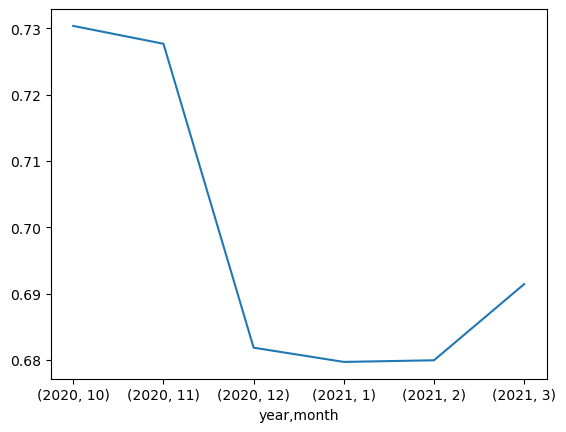

In [40]:
_ = results_df.reset_index()


_['year'] = _['index'].dt.year
_['month'] = _['index'].dt.month

_.groupby(['year','month'])['acc'].mean().plot()

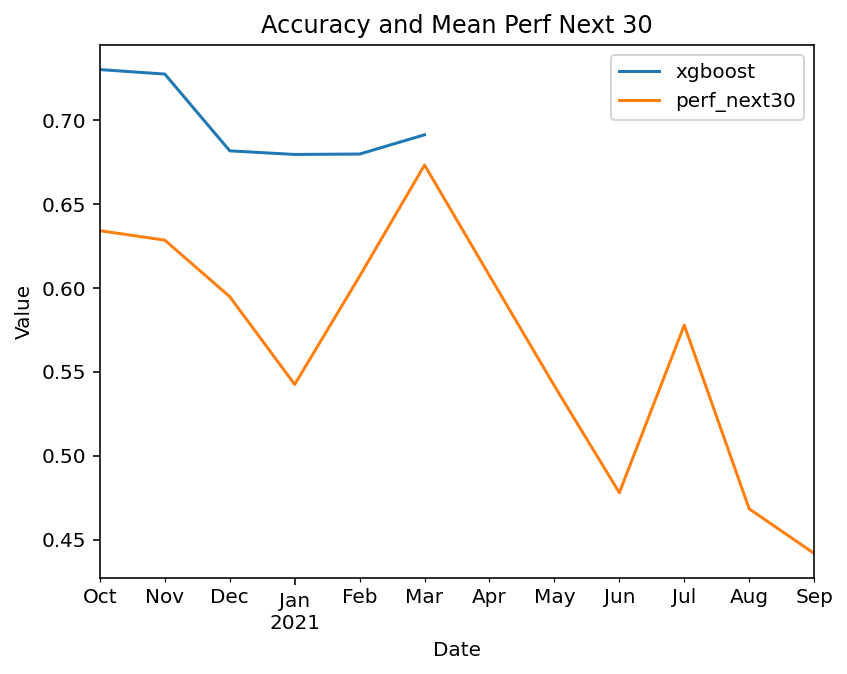

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=144)

# 设置results的index为日期范围
date_range = pd.date_range(start='2020-10-01', end='2021-04-30', freq='D')
results_df = pd.DataFrame(results, index=date_range[:len(results)])

# 按年月聚合acc的均值
results_df['year'] = results_df.index.year
results_df['month'] = results_df.index.month
results_df_monthly = results_df.groupby(['year', 'month'])['acc'].mean().reset_index()
results_df_monthly['date'] = pd.to_datetime(results_df_monthly['year'].astype(str) + '-' + results_df_monthly['month'].astype(str))

results_df_monthly.plot(x='date', y='acc', ax=ax, label='xgboost')

# results_df.acc.plot(ax=ax, label='Accuracy')

df.groupby('created_day').agg({
    'perf_next30': 'mean'
}).plot(ax=ax, label='Mean Perf Next 30')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Accuracy and Mean Perf Next 30')
plt.legend(loc="upper right")
plt.show()